<h1><center> Klasifikator </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

Potrebno je u anaconda prompt-u instalirati xgboost s:<br>
<code>conda install -c anaconda py-xgboost</code>

### Priprema

In [2]:
# potrebni paketi
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot
from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

In [3]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

In [4]:
# učitavanje svih značajki iz training skupa
selected_features = pd.read_csv('selected_features_pca_train_cv2.csv')

In [5]:
selected_features = selected_features[list(selected_features.columns.values[:40])]

In [5]:
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [6]:
selected_features.head()

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39
0,0,1.674513,-3.059634,-3.894463,3.289645,0.150883,-1.472087,-0.024001,0.238912,0.142270,...,0.151829,-0.514771,-0.084412,0.068432,0.073591,-0.089930,0.065747,0.070795,0.097492,0.132126
1,1,5.906251,1.554144,-2.833053,2.938874,0.805299,-3.636518,-0.402669,0.606742,1.311709,...,0.044457,-0.284964,-0.490513,0.064460,-0.248158,0.136959,0.022552,-0.000118,0.120075,0.210595
2,2,3.221069,-2.617408,-3.272275,2.647972,-0.069620,-4.990653,-0.219473,1.012171,0.981318,...,-0.125125,0.254433,-0.620814,0.336074,-0.126646,0.228267,0.082945,-0.081503,0.223538,0.441006
3,3,18.763987,17.527091,-0.863160,0.153083,-2.711496,-0.721077,-0.585667,6.261385,-0.466834,...,0.256698,-4.040179,-5.343816,2.850072,-0.593122,0.928882,-0.029514,0.358611,1.513826,2.976356
4,4,1.093519,-0.463915,-3.847778,1.583634,-2.348521,-0.712134,1.890559,-1.005999,0.738036,...,0.063579,-0.321892,-0.229663,-0.044180,0.407910,0.029281,0.068431,-0.061297,0.152343,0.453407


In [35]:
#postavljanje seed-a za podjelu podataka na train i test
seed = 40

In [34]:
X=selected_features.iloc[:,1:187]
y=features.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

### XGBClassifier

In [47]:
def model_test(model, X_test, y_test):
    
    preds = model.predict_proba(X_test)
    #preds=np.clip(preds, 0.025,0.975)
    best_preds = model.predict(X_test)

    score_log = log_loss(y_test,preds,eps=1e-15)
    score_acc = accuracy_score(y_test, best_preds)

    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    make_and_plot_confusion_matrix(y_test,best_preds)


###  confusion matrix

In [49]:
#funkcija koja računa i crta matricu konfuzije
def make_and_plot_confusion_matrix(y_test, best_preds):
    names = ['class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8', 'class 9']
    cm = confusion_matrix(y_test, best_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    norm_conf = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.Blues, interpolation='nearest')

    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(format(round(cm[x][y], 2))), xy=(y, x), horizontalalignment='center', verticalalignment='center')
    plt.title('Confusion matrix')
    cb = fig.colorbar(res)
    plt.xticks(range(width), names)
    plt.yticks(range(height), names)

In [43]:
params['n_estimators'] = 200

### testiranje parametara

### isto samo s neg_log_loss

In [11]:
model = RandomForestClassifier()

In [19]:
bootstrap_range = [True, False]
max_depth_range = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
max_features_range = ['auto', 'sqrt']
min_samples_leaf_range = [1, 2, 4]
min_samples_split_range = [2, 5, 10]
n_estimators_range = [100, 200, 400, 600]

param_ranges = dict(bootstrap=bootstrap_range,
                    max_depth=max_depth_range,
                    max_features=max_features_range,
                    min_samples_leaf=min_samples_leaf_range, 
                    min_samples_split=min_samples_split_range,
                    n_estimators=n_estimators_range)

In [20]:
# koristimo RandomizedSearchCV za testiranje parametara
# neg_log_los je bolji što je veći(suprotno od logloss). Ovdje se ne može koristiti logloss
rand_search = RandomizedSearchCV(model, param_ranges, cv=4, scoring='neg_log_loss', n_iter=30, 
                                 random_state=5, return_train_score=False, n_jobs=-1)
rand_search.fit(X, y)

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [21]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(rand_search.cv_results_)[['mean_test_score', 'params']]


,mean_test_score,params
0,-0.097419,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}"
1,-0.380832,"{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}"
2,-0.081359,"{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}"
3,-0.093788,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}"
4,-0.117801,"{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}"
5,-0.118403,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}"
6,-0.094881,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}"
7,-0.078766,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}"
8,-0.087188,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}"
9,-0.101458,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}"


In [43]:
# dohvaćanje najboljih parametara
print(rand_search.best_score_)
print(rand_search.best_params_)
#param4=rand_search.best_params_

-0.07574089883042273
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False, 'objective': 'multi:softprob'}


Dobili smo jednak rezultat za accuracy i za logloss tako da ćemo uzeti te parametre

In [28]:
params=param4

In [25]:
params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False,
 'objective': 'multi:softprob'}

<br>
<br>

Logloss:0.06798612000724681
Accuracy:0.9871205151793928


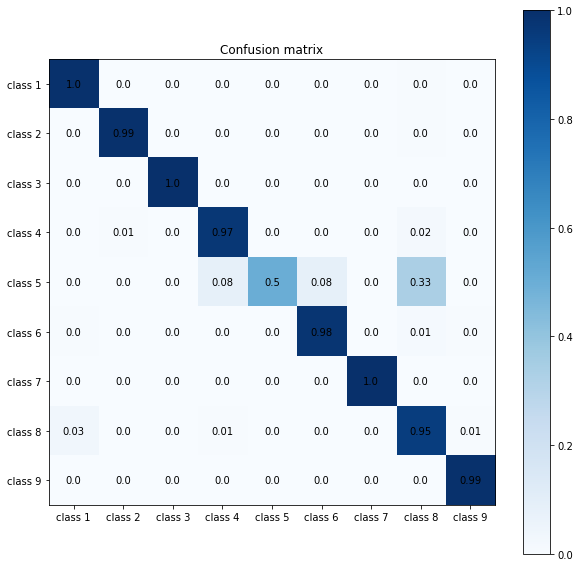

In [73]:
params={'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 60,
    'bootstrap': False}

#xgboost na selektiranim značajkama
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)

## Pokušaji rješavanja nebalasiranosti podataka

### oversampling

[(1, 2036), (2, 2036), (3, 2036), (4, 2036), (5, 2036), (6, 2036), (7, 2036), (8, 2036), (9, 2036)]
Logloss:0.06942285292990785
Accuracy:0.9862005519779209


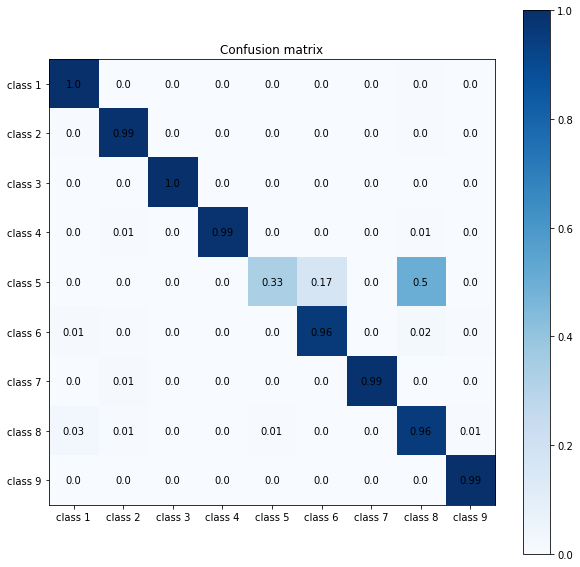

In [60]:
#RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)

[(1, 2036), (2, 2036), (3, 2036), (4, 2036), (5, 2036), (6, 2036), (7, 2036), (8, 2036), (9, 2036)]
Logloss:0.0658734234794313
Accuracy:0.9883471327813554


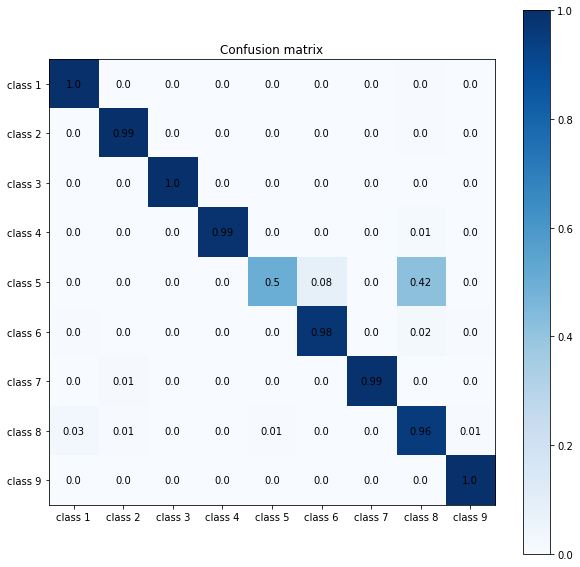

In [61]:
#SMOTE
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)


[(1, 2021), (2, 2034), (3, 2036), (4, 2031), (5, 2031), (6, 2026), (7, 2040), (8, 2028), (9, 2025)]
Logloss:0.07434448517509806
Accuracy:0.9892670959828274


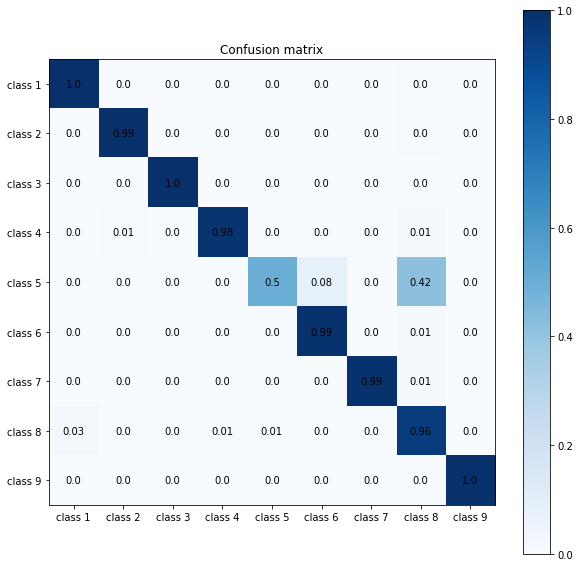

In [63]:
#ADASYN
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)

### undersample

[(1, 1084), (2, 1753), (3, 30), (4, 332), (5, 30), (6, 506), (7, 278), (8, 881), (9, 706)]
Logloss:0.1107437042134844
Accuracy:0.9855872431769396


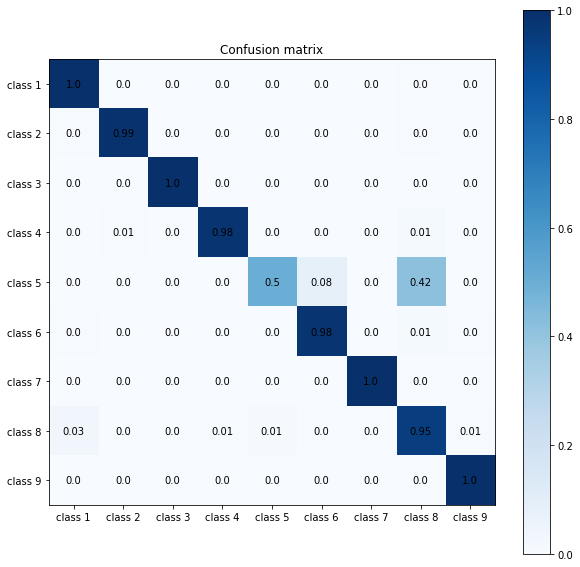

In [64]:
#RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)

## bagging

Logloss:0.0820260096371637
Accuracy:0.9868138607789022


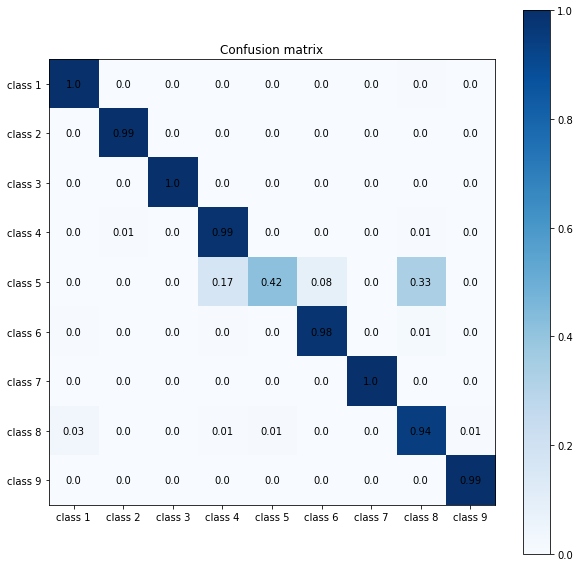

In [66]:
#BaggingClassifier iz sklearn-a, ali čini mi se da moramo koristit XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

rf = RandomForestClassifier(**params)

model = BaggingClassifier(base_estimator=rf, n_estimators=10, random_state=seed)
model.fit(X_train, y_train)

model_test(model,X_test,y_test)

### ručni kvazi-bagging

In [71]:
def bagging_custom(n_bags, test_index, train_index, train_X, test_X, train_y):
    
    bags = n_bags#broj bag-ova
    test_pred_prob = np.zeros((len(test_index),9))
    for bg in range(bags):
        #new_train_index je prvo samo izmješani train_index
        new_train_index = random.sample(list(train_index), int(len(train_index) * 1.))
        #dodajemo mi nasumične brojeve iz train_index (s ponavljanjem)
        for i in range(int(len(train_index) * 1.)):
            new_train_index.append(random.choice(train_index))

        train_X=X.iloc[new_train_index,:]
        train_y=y.iloc[new_train_index]

        rf = RandomForestClassifier(**params)
        rf.fit(X_train, y_train)

        preds = rf.predict_proba(test_X) 

        print("Bag " + str(bg+1))
        
        #zbrajamo vjerojatnosti od svih bag-ova
        test_pred_prob += preds
    #izračunamo prosječne vjerojatnosti pa onda klase
    pred_prob = test_pred_prob / bags
    best_preds = np.asarray([np.argmax(line) for line in pred_prob])
    return best_preds, pred_prob

### kfold

In [72]:
X=selected_features.iloc[:,1:187]
y=features.iloc[:,1]

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1000)

predicted = []
original = []
log_losses = []
accuracies = []
fold_counter = 0
misclassified_counter = 1
for train_index, test_index in kfold.split(X,y):
    fold_counter += 1
    train_X=X.iloc[train_index,:]
    train_y=y.iloc[train_index]
    test_X=X.iloc[test_index,:]
    test_y=y.iloc[test_index]
    #----------
    pred = bagging_custom(5, test_index, train_index, train_X, test_X, train_y) 
    #----------
    test_y = [int(x-1) for x in test_y]
    
    score_log = log_loss(test_y,pred[1],eps=1e-15)
    score_acc = accuracy_score(test_y, pred[0])

    log_losses.append(score_log)
    accuracies.append(score_acc)
    
    predicted.extend(pred[0])
    original.extend(test_y)
    
    print('-----------------------------------')
    print('FOLD '+ str(fold_counter))
    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    for i in range(len(pred[0])):
        if pred[0][i] != test_y[i]:
            print ('Missed! ' + 'actual='+str(test_y[i]+1) + ' predicted='+str(pred[0][i]+1))
            misclassified_counter += 1

predicted = np.array(predicted)
original = np.array(original)
print ('===========================================')
print('In total {} misclassified samples'.format(misclassified_counter-1))
print('Accuracy mean : ' + str(np.mean(accuracies)))
print('log loss mean : ' + str(np.mean(log_losses)))


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
-----------------------------------
FOLD 1
Logloss:0.020138355309742527
Accuracy:0.9958601655933763
Missed! actual=4 predicted=2
Missed! actual=5 predicted=6
Missed! actual=5 predicted=4
Missed! actual=8 predicted=9
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=9 predicted=1
Bag 1
Bag 2


KeyboardInterrupt: 

# kraj

In [75]:
selected_features_test = pd.read_csv('selected_features_rfc_test_cv2.csv')

In [112]:
X_test=selected_features_test.iloc[:,1:10873]
train_index=X.iloc[:,0]
test_index=selected_features_test.iloc[:,0]

pred = bagging_custom(10, test_index, train_index, X, X_test, y) 


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10


# submission
bez headera

In [69]:
# load Id column of testset
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")
# drop first colum that was left -> fix this and save dataframe without that column
md5hash_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [114]:
df = pd.DataFrame(pred[1])
result = pd.concat([md5hash_test, df], axis=1, sort=False)
result.to_csv('submisson.csv')

,0,1,2,3,4,5,6,7,8
0,0.000232,0.000235,0.000194,0.000189,0.996269,0.001132,0.000516,0.000890,0.000341
1,0.000069,0.000142,0.000056,0.000055,0.998794,0.000235,0.000281,0.000187,0.000183
2,0.000150,0.000196,0.000106,0.000145,0.998160,0.000257,0.000282,0.000514,0.000188
3,0.003723,0.006853,0.003120,0.004150,0.939744,0.015020,0.003415,0.019795,0.004180
4,0.000017,0.000014,0.999821,0.000015,0.000037,0.000026,0.000024,0.000024,0.000022
...,...,...,...,...,...,...,...,...,...
10868,0.000011,0.000009,0.999891,0.000010,0.000022,0.000015,0.000014,0.000014,0.000014
10869,0.000023,0.000138,0.000023,0.000043,0.000046,0.000046,0.999606,0.000048,0.000027
10870,0.000009,0.000009,0.999892,0.000010,0.000017,0.000016,0.000021,0.000011,0.000015
10871,0.000017,0.999795,0.000018,0.000011,0.000022,0.000019,0.000015,0.000031,0.000073


In [ ]:
preds_clipped=np.clip(preds, 0.025,0.975)